In [1]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from src.functions import *

In [2]:
from src.db_connection import DatabaseConnector

db_connector = DatabaseConnector('horse')

db_connector.connect()

query = "select * from df1 where Course = 'Ascot'"

df = db_connector.fetch_data(query)

db_connector.disconnect()

df.head()

Connected to the database
Disconnected from the database


,Race Time,Course,Distance (y),Draw,Weight Rank,Breakfast Price,Morning Price,SP Odds Decimal,"Won (1=Won, 0=Lost)","Place (1=Placed, 0=UnPlaced)",Trainer/Jky Stats Rank,WON SR Before,Position LTO,Horse Stats Rank,Proform Speed Rating,WON SR Before_[0],unique_id,unique_id_int
0,2020-10-02 13:55:00,Ascot,1760,1,1,6.5,7.5,19.00,0,0,6,21.88,1.0,3,63,21.88,2020-10-02 13:55:00_Ascot,16
1,2020-10-02 13:55:00,Ascot,1760,2,1,5.0,6.5,6.00,0,0,5,7.69,4.0,5,62,7.69,2020-10-02 13:55:00_Ascot,16
2,2020-10-02 13:55:00,Ascot,1760,6,1,11.0,15.0,19.00,0,0,1,25.00,8.0,2,49,25.00,2020-10-02 13:55:00_Ascot,16
3,2020-10-02 13:55:00,Ascot,1760,5,1,4.5,4.5,3.75,0,0,3,0.00,14.0,6,60,0.00,2020-10-02 13:55:00_Ascot,16
4,2020-10-02 13:55:00,Ascot,1760,3,5,6.5,5.0,4.00,0,1,4,33.33,3.0,4,68,33.33,2020-10-02 13:55:00_Ascot,16


In [3]:
features = df[['Draw', 'Weight Rank', 'SP Odds Decimal', 
               'Trainer/Jky Stats Rank', 'WON SR Before', 'Position LTO', 'Horse Stats Rank', 'Proform Speed Rating']]

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [5]:
n_components = 5

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_features)

In [6]:
explained_variance = pca.explained_variance_ratio_

In [7]:
cum_explained_var = explained_variance.cumsum()

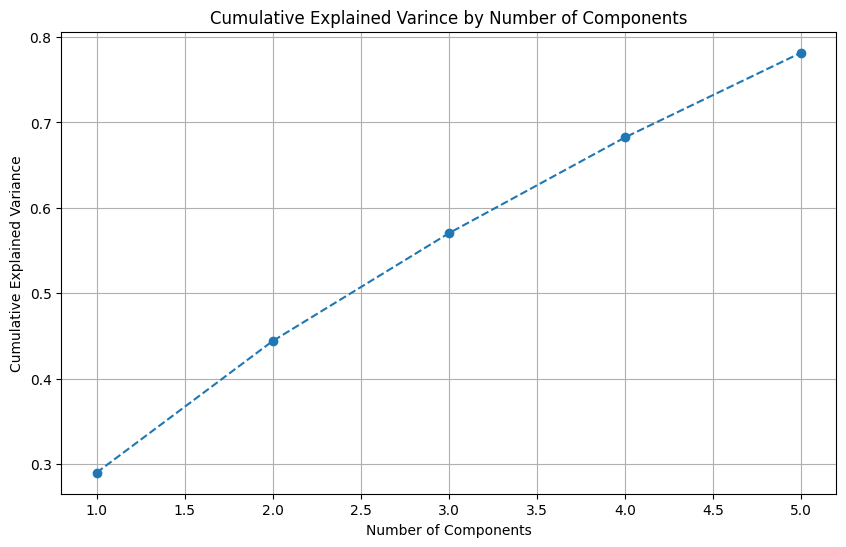

In [8]:
plt.figure(figsize=(10,6))
plt.plot(range(1, n_components + 1), cum_explained_var, marker = 'o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Varince by Number of Components')
plt.grid(True)
plt.show()

In [9]:
components = pca.components_

components_df = pd.DataFrame(components, columns = features.columns)

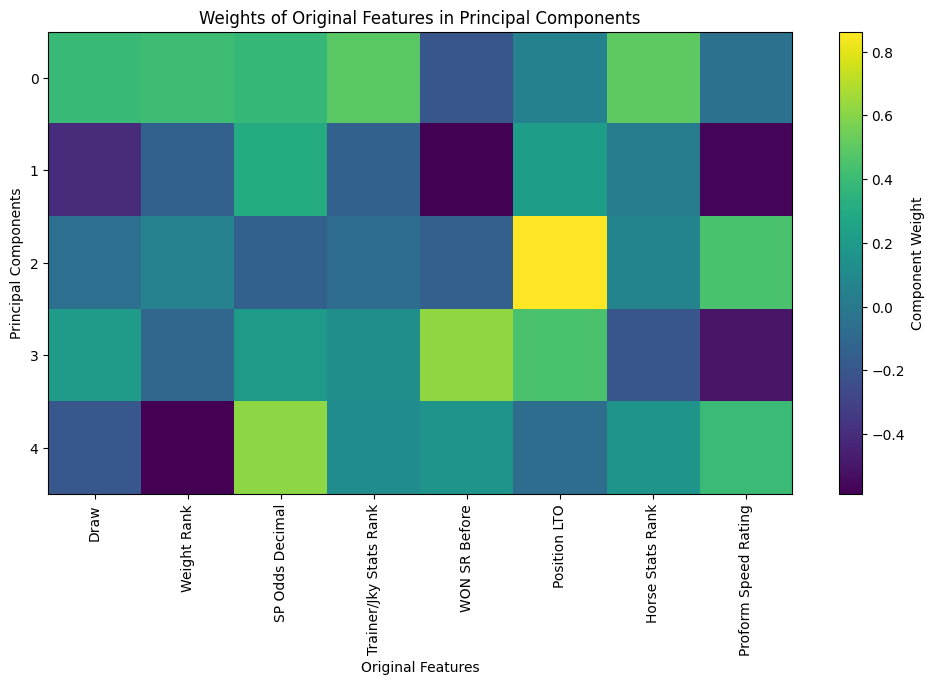

In [10]:
plt.figure(figsize = (12,6))
plt.imshow(components_df, cmap='viridis', aspect = 'auto')
plt.colorbar(label='Component Weight')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.title('Weights of Original Features in Principal Components')
plt.xticks(ticks=range(len(features.columns)), labels=features.columns, rotation=90)
plt.show()

In [11]:
train_data, test_data = split_data(df, 'unique_id_int', test_size=0.2)

# Extract features and target variable for training and testing sets
train_features = train_data[['Draw', 'Weight Rank', 'SP Odds Decimal', 
               'Trainer/Jky Stats Rank', 'WON SR Before', 'Position LTO', 'Horse Stats Rank', 'Proform Speed Rating']]

train_target = train_data['Won (1=Won, 0=Lost)']

test_features = test_data[['Draw', 'Weight Rank', 'SP Odds Decimal', 
               'Trainer/Jky Stats Rank', 'WON SR Before', 'Position LTO', 'Horse Stats Rank', 'Proform Speed Rating']]

test_target = test_data['Won (1=Won, 0=Lost)']

# Initialize StandardScaler()
scaler = StandardScaler()

# Fit and and transform
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

In [12]:
print(len(train_target))

print(len(scaled_train_features))

1390
1390


In [16]:
# Apply PCA to the standardized data
run_name = 'rf_loop_pca_'
with mlflow.start_run(run_name=run_name):

    pca = PCA(n_components=6)  # Choose the number of components to retain
    
    X_train_pca = pca.fit_transform(scaled_train_features)
    X_test_pca = pca.transform(scaled_test_features)

    clf = RandomForestClassifier(n_estimators=50, random_state=42)

    # Train the model using the training data
    clf.fit(X_train_pca, train_target)

    # Make predictions on the test set
    predictions = clf.predict(X_test_pca)

    # Evaluate the model
    eval_print_log(test_target, predictions)

    mlflow.end_run()

Accuracy: 0.8896321070234113
Precision: 0.25
Recall: 0.03225806451612903
F1 score: 0.05714285714285715
ROC AUC score: 0.5105320173326914


In [14]:
# Assuming 'pca' is your fitted PCA model

# Get the principal components
components = pca.components_

# Create a DataFrame to associate each original feature with its weights in each component
components_df = pd.DataFrame(components, columns=features.columns)

# Calculate the absolute values of the weights
abs_components_df = np.abs(components_df)

# Get the average importance of each original feature across all components
average_feature_importance = abs_components_df.mean()

# Sort features by their average importance
sorted_feature_importance = average_feature_importance.sort_values(ascending=False)

# Display the feature importance
print("Feature Importance after PCA:")
print(sorted_feature_importance)


Feature Importance after PCA:
Proform Speed Rating      0.379875
Position LTO              0.359936
WON SR Before             0.327025
SP Odds Decimal           0.293535
Draw                      0.286162
Trainer/Jky Stats Rank    0.237191
Weight Rank               0.236756
Horse Stats Rank          0.198539
dtype: float64


In [15]:
components_df

,Draw,Weight Rank,SP Odds Decimal,Trainer/Jky Stats Rank,WON SR Before,Position LTO,Horse Stats Rank,Proform Speed Rating
0,0.384218,0.407757,0.389447,0.484199,-0.203153,0.036575,0.496370,-0.104887
1,-0.424264,-0.162831,0.312856,-0.160832,-0.568881,0.242452,0.009645,-0.535947
2,-0.050004,0.139679,-0.178300,-0.066542,-0.209040,0.800783,0.089604,0.498790


In [17]:
# utilising SelectKBest
from sklearn.feature_selection import SelectKBest, chi2

# Instantiate SelectKBest with a specific scoring function (e.g., chi-squared)
selector = SelectKBest(score_func=chi2, k=5)  # Select top 5 features using chi-squared test

# Fit-transform on training data
X_train_selected = selector.fit_transform(train_features, train_target)

# Transform test data based on the features selected in training
X_test_selected = selector.transform(test_features)



In [20]:
# Get selected feature indices
selected_indices = selector.get_support(indices=True)

# Get original feature names
original_feature_names = train_features.columns  # Assuming X is your DataFrame or array with original features

# Get selected feature names
selected_feature_names = original_feature_names[selected_indices]

# Print selected feature names
print("Selected Feature Names:")
print(selected_feature_names)

# If you're using a specific scoring function like chi2, you might not get coefficients directly.
# However, if using mutual_info_classif, f_classif, or similar, you might get scores/importances

# Retrieve scores/importances (if applicable)
feature_scores = selector.scores_  # Retrieves the scores of features based on the selected scoring function

# Print scores/importances of selected features
print("Scores of Selected Features:")
print(feature_scores[selected_indices])


Selected Feature Names:
Index(['SP Odds Decimal', 'Trainer/Jky Stats Rank', 'WON SR Before',
       'Horse Stats Rank', 'Proform Speed Rating'],
      dtype='object')
Scores of Selected Features:
[1408.9857918    87.42031761  119.26896854   89.46009755  115.62740495]
